In [5]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import time
from sklearn import metrics

from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from matplotlib import pyplot as plt

from torch.utils import data as torch_data
from torch.utils.data import Dataset
from torch.autograd import Variable

from scipy import interpolate
import argparse



torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device='cuda:2'
print("device=",device)

class Config:

    train_dir="m5C/feature/train/"
    test_dir="ELIGOS_C/feature/test/"
    #train_dir = "data/motif/CTCAC/train/"
    #test_dir = "data/motif/CTCAC/test/"
    batch_size = 500
    learning_rate=0.00001

  
        
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x=x
        self.y=y

    def __getitem__(self, index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.x)

class BahdanauAttention(nn.Module):
    """
    input: from RNN module h_1, ... , h_n (batch_size, seq_len, units*num_directions),
                                    h_n: (num_directions, batch_size, units)
    return: (batch_size, num_task, units)
    """
    def __init__(self,in_features, hidden_units,num_task):
        super(BahdanauAttention,self).__init__()
        self.W1 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.W2 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.V = nn.Linear(in_features=hidden_units, out_features=num_task)

    def forward(self, hidden_states, values):
        hidden_with_time_axis = torch.unsqueeze(hidden_states,dim=1)

        score  = self.V(nn.Tanh()(self.W1(values)+self.W2(hidden_with_time_axis)))
        attention_weights = nn.Softmax(dim=1)(score)
        values = torch.transpose(values,1,2)   # transpose to make it suitable for matrix multiplication
        #print(attention_weights.shape,values.shape)
        context_vector = torch.matmul(values,attention_weights)
        context_vector = torch.transpose(context_vector,1,2)
        return context_vector, attention_weights

class NN(nn.Module):
    def __init__(self,num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5):
        super(NN,self).__init__()

        self.seq_len=seq_len
        self.embed = nn.Embedding(vocab_zie, embedding_size)

        self.cnn_1d = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7,stride=2,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),

        )
        self.lstm=nn.LSTM(input_size=128,hidden_size=128,batch_first=True,bidirectional=True)
        self.attention=BahdanauAttention(in_features=256,hidden_units=10,num_task=1)
        self.fc = nn.Sequential(
            nn.Linear(in_features=1536,out_features=1536),
            nn.ReLU(),
            nn.Linear(in_features=1536, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=2)
        )

        self.lstm_seq=nn.LSTM(input_size=4+5,hidden_size=128,batch_first=True,bidirectional=True)   #embedding_size+feature_num


    def seq_to_digit(self,seq):
        return torch.Tensor([{'A': 0, "C": 1, "G": 2, "T": 3}[i] for i in list(seq)]).long()


    def forward(self,x,kmer,mean,std,intense,dwell,base_quality):

        kmer_embedded=self.embed(kmer)
        mean = torch.reshape(mean, (-1, self.seq_len, 1)).float()
        std = torch.reshape(std, (-1, self.seq_len, 1)).float()
        intense = torch.reshape(intense, (-1, self.seq_len, 1)).float()
        dwell = torch.reshape(dwell, (-1, self.seq_len, 1)).float()
        base_quality = torch.reshape(base_quality, (-1, self.seq_len, 1)).float()
        
        out_seq=torch.cat((kmer_embedded,mean,std,intense,dwell,base_quality),2)


        out_seq,(h_n_seq,c_n_seq)=self.lstm_seq(out_seq)

        x = self.cnn_1d(x)

        batch_size, features, seq_len = x.size()
        x = x.view(batch_size, seq_len, features)  # parepare input for LSTM

        output, (h_n, c_n) = self.lstm(x)

        h_n = h_n.view(batch_size, output.size()[-1])  # pareprae input for Attention
        context_vector, attention_weights = self.attention(h_n, output)  # Attention (batch_size, num_task, unit)


        out=torch.cat((out_seq[:,0,:],out_seq[:,1,:],out_seq[:,2,:],out_seq[:,3,:],out_seq[:,4,:],context_vector[:,0,:]),1)
        #out=context_vector[:,0,:]
        out.view(out.size()[0],1,out.size()[1])

        x=self.fc(out)
        #x.view(x.size()[0], 1, x.size()[1])
       
        return x


def make_weights_for_balanced_classes(images, nclasses):
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
    return weight

from torch.utils.data import WeightedRandomSampler
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """WeightedRandomSampler except allows for more than 2^24 samples to be sampled"""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(range(0, len(self.weights)),
                                       size=self.num_samples,
                                       p=self.weights.numpy() / torch.sum(self.weights).numpy(),
                                       replace=self.replacement)
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())



print("loading data...")



model = NN(num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

loss_func = torch.nn.CrossEntropyLoss()#.to(device)

 
#predict_result=open("rice/results/WT_precit_results.tsv","w")


def predict(model):

    
    file=open(feature)
    count=0
    while True:
        
        count+=1
        lines = file.readlines(50000)
        #print(count,len(lines))
        if not lines:
            break
        
        X,Y=[],[]
        try:
            kmer_encode_dic={'A': 0, "C": 1, "G": 2, "T": 3}
            for line in lines:
                read_id=line.split("\t")[0]
                contig=line.split("\t")[1]
                position=line.split("\t")[2]
                motif=line.split("\t")[3]

                signals="|".join(line.split("\t")[9:14]).split("|")
                signal=np.array([float(signal) for signal in signals])
                #signal=(signal-np.mean(signal))/np.std(signal)
                kmer = line.split("\t")[3]
                kmer=np.array([kmer_encode_dic[base] for base in kmer])
                mean = np.array([float(item) for item in line.split("\t")[4].split("|")])
                std = np.array([float(item) for item in line.split("\t")[5].split("|")])
                intense = np.array([float(item) for item in line.split("\t")[6].split("|")])
                dwell = np.array([float(item) for item in line.split("\t")[7].split("|")])/200
                base_quality = np.array([float(item) for item in line.split("\t")[8].split("|")])/40

                X.append([signal,kmer,mean,std,intense,dwell,base_quality])
                Y.append("|".join([contig,position,motif,read_id]))


            dataset=MyDataset(X,Y)
            dataloader=torch.utils.data.DataLoader(dataset=dataset,batch_size=20000)

            test_acc = 0.
            y_test = []
            y_pred = []
            label_dict={0:"C",1:"m5C",2:"ac4C"}

            for i,(batch_x, batch_y) in enumerate(dataloader):

                signal, kmer, mean, std, intense, dwell,base_quality = batch_x
                signal= Variable(signal.to(device)).to(torch.float32)

                kmer = Variable(kmer.to(device)).to(torch.long)
                mean = Variable(mean.to(device)).to(torch.float32)
                std = Variable(std.to(device)).to(torch.float32)
                intense = Variable(intense.to(device)).to(torch.float32)
                dwell = Variable(dwell.to(device)).to(torch.float32)
                base_quality = Variable(base_quality.to(device)).to(torch.float32)
                batch_size, features = signal.size()
                signal = signal.view(batch_size, 1, features)

                out = model(signal, kmer, mean, std, intense, dwell,base_quality )
                batch_size, out_channels = out.size()

                out = out.view(batch_size, out_channels)
                pred = torch.max(out, 1)[1].cpu().numpy()

                out=torch.softmax(out,dim=1)
                probabilities=out.detach().cpu().numpy()[:,2]


                for j in range(len(batch_y)):

                    contig,position,motif,read_id=batch_y[j].split("|")
                    print("%s\t%s\t%s\t%s\t%s\t%s" %(contig,position,motif,read_id,label_dict[pred[j]],probabilities[j]),file=predict_result)
        except Exception as e:
            print(e)
        
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Extract feature from signal.')


    #parser.add_argument('-feature', default='BaseCalled_template',help='Basecall subgroup Nanoraw resquiggle into. Default is BaseCalled_template')
    #parser.add_argument('-out', default='BaseCalled_template',help='Basecall subgroup Nanoraw resquiggle into. Default is BaseCalled_template')

    #args = parser.parse_args()
    

    #predict_result=open(args.out,"w")        
    model= torch.load('/home/yulab/projects/ac4c/model/C_m5C_ac4C_3_class_10.pkl',map_location=device)  #0.75
    #model= torch.load('/home/yulab/projects/ac4c/model/C_m5Cac4C.pkl',map_location=device)  #0.75
    #model= torch.load('/home/yulab/projects/ac4c/model/m5C_ac4C_8.pkl',map_location=device)  #0.75
    #model= torch.load('model/m5C_Os_AD_median_mad.pkl')  #0.145
    #model= torch.load('model/m5C_Os_AD_median_mad_2.21.pkl')  #0.145
    feature="/home/yulab/projects/ac4c/data/HeLa/WT.2.feature"
    out="/home/yulab/projects/ac4c/data/4_12/HeLa.WT2.predict"

    predict_result=open(out,"w")
    predict(model)
    predict_result.close()

    #predict_result.close() 


#222222222222222222222222222

/home/yulab/anaconda3/envs/TandemMod/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device= cuda:2
loading data...


In [5]:
#merge 

#cat HeLa.WT1.predict HeLa.WT2.predict HeLa.WT3.predict >HeLa.WT.predict


mod_dict={}

with open("data/4_12/HeLa.WT.predict") as f:
    for line in f:
        line=line.rstrip()
        contig,site,motif,read_id,label,probability=line.split("\t")

        key="|".join([contig,site])

        if key not in mod_dict:
            mod_dict[key]=[0,0]
        if float(probability)>0.7:
            mod_dict[key][0]+=1
        mod_dict[key][1]+=1


In [10]:
transcript_id_dict={}

with open("data/HeLa/GRCh38_latest_rna.fna") as f:
    for line in f:
        if line[0] == ">":
            transcript_id=line.split(" ")[0][1:]
            gene_id=line.split("(")[1].split(")")[0]
            transcript_id_dict[transcript_id]=gene_id




out=open("data/4_12/WT.3class.predict.merge","w")
for id in mod_dict:
    if mod_dict[id][1]>20 and mod_dict[id][0]/mod_dict[id][1]>0.25:
        contig,site=id.split("|")
        try:
            pass
            #contig=transcript_id_dict[contig]
        except:
            continue
        out.write("%s\t%s\t%s\n" %(transcript_id_dict[contig],site,int(site)+1))
        id="%s\t%s\t%s\n" %(transcript_id_dict[contig],site,int(site)+1)

out.close()

In [11]:
#random
all_transcript_list=[]


print(len(mod_dict))
count=1
for key in mod_dict:
    if mod_dict[key][1]>20 :
        all_transcript_list.append(key)


import random
random_transcript_list=random.sample(all_transcript_list,7133)


with open("data/4_12/random.bed","w") as out:
    for key in random_transcript_list:
        transcript_id,site=key.split("|")


        gene_id=transcript_id_dict[transcript_id]

        out.write("%s\t%s\t%s\n" %(gene_id,site,int(site)+1))

8075527


In [9]:


bedtools intersect  -a /home/yulab/projects/ac4c/data/HeLa/acRIP.bed -b /home/yulab/projects/ac4c/data/4_12/WT.3class.predict.merge -wa >acRIP_overlap_with_predict.txt
#1718/7133

bedtools intersect  -a /home/yulab/projects/ac4c/data/HeLa/acRIP.bed -b /home/yulab/projects/ac4c/data/HeLa/RedaCTseq.bed -wa >acRIP_overlap_with_Redac.txt
#777/6955

#random
bedtools intersect  -a /home/yulab/projects/ac4c/data/HeLa/acRIP.bed -b /home/yulab/projects/ac4c/data/4_12/random.bed -wa >acRIP_overlap_with_random.txt




In [37]:
with open("/home/yulab/projects/ac4c/data/HeLa/acRIP.bed") as f:
    ac4C_gene_list=[]
    for line in f:
        gene=line.split("\t")[0]
        if gene not in ac4C_gene_list:
            ac4C_gene_list.append(gene)
    print(len(set(ac4C_gene_list)))

2139


In [38]:
file="data/HeLa/GSE102113_RiboSeq_processed_data.csv"

"""
all_gene_list=[]
with open(file) as f:
    for line in f:
        gene_id=line.split("\t")[0]
        all_gene_list.append(gene_id)
"""
ucsc_id_dict={}
with open("ucsc_to_gene_symbol.tsv") as f:
    for line in f:
        line=line.rstrip()
        try:
            ucsc_id,gene_symbol=line.split("\t")
            ucsc_id_dict[ucsc_id]=gene_symbol
        except:
            pass


TE_dict={}
with open(file) as f:
    for line in f:
        ucsc_id,p5_len,CDS_len,p3_len,condition,replicate,RNA_FPM,RPF_5p_FPM,RPF_CDS_FPM,RPF_3p_FPM,ac4c_peaks=line.split(",")
        if condition != "WT":
            continue
        if replicate != "1":
            continue
        
        if float(RNA_FPM) == 0:
            continue

        TE=(float(RPF_5p_FPM)+float(RPF_CDS_FPM)+float(RPF_CDS_FPM))/float(RNA_FPM)
        try:
            gene_id=ucsc_id_dict[ucsc_id]
        except:
            continue

        TE_dict[gene_id]=TE

In [39]:


mod_dict={}

with open("data/4_12/HeLa.WT.predict") as f:
    for line in f:
        line=line.rstrip()
        contig,site,motif,read_id,label,probability=line.split("\t")

        key="|".join([contig,site])

        if key not in mod_dict:
            mod_dict[key]=[0,0]
        if float(probability)>0.7:
            mod_dict[key][0]+=1
        mod_dict[key][1]+=1

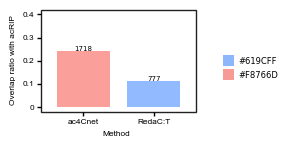

/home/yulab/anaconda3/envs/TandemMod/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 2 x 1.33 in image.
/home/yulab/anaconda3/envs/TandemMod/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure/validation_of_ac4Cnet_using_acRIP.pdf
findfont: Font family ['Arial'] not found. Falling back to Helvetica.
findfont: Font family ['Dejavu Sans'] not found. Falling back to Helvetica.
findfont: Font family ['Dejavu Sans'] not found. Falling back to Helvetica.


In [1]:
#plot




import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import numpy as np

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"

import re

method=["ac4Cnet","RedaC:T"]

overlap=[1718/7133,777/6955]

number=[1718,777]

color=[c1,c3]

plt.rcParams["pdf.use14corefonts"] = True

data=pd.DataFrame({"Method":method,"Overlap ratio":overlap,"number":number})
#data=data.sort_values(by=['m6A/A ratio'],ascending=False)        #sort
data['Method'] = pd.Categorical(data['Method'], categories=pd.unique(data['Method']))  #reorder legend

p=(
    ggplot()
    +geom_bar(data,aes(x="Method",y="Overlap ratio",width=0.75,fill="color"),alpha=0.7,stat="identity")   
    +geom_text(data,aes(x="Method",y="Overlap ratio",label="number"),format_string='{:.0f}',size=5,va="bottom")
    #+scale_x_continuous(breaks = [0,100,200,300],labels =["               5'UTR", "                CDS", "                3'UTR",""])
    +theme(panel_background=element_rect(fill=gray, alpha=0),
            strip_text_x = element_text(size = 6),            #facet font size
            #legend_position = "none",
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            #axis_text_x=element_text(size=6,family="Monospace",color="black",angle=45),
            axis_text_x=element_text(size=6,family="Arial",color="black",angle=0),
            axis_text_y=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
             
            figure_size=[2,1.33],
            legend_title = element_text(size=6,alpha=0), #change legend title font size
            legend_text = element_text(size=6),
            legend_background=element_rect(size=0.5,alpha=0),
            legend_position=None,
            #legend_position=(0.70,0.75), 
            legend_key_size=8) #change legend text font size)
            
    #+ geom_vline(xintercept=100,linetype="dashed",alpha=0.5)
    #+ geom_vline(xintercept=200,linetype="dashed",alpha=0.5)
    +ylim([0,0.4])
    #+xlim([0,0.20])
    #+facet_wrap("site")
    +scale_fill_manual(values=[ c3,c1]) 
    +ylab("Overlap ratio with acRIP")
)

print(p)
p.save('figure/validation_of_ac4Cnet_using_acRIP.pdf')

In [47]:
mod_ratio_dict={}

for id in mod_dict:
    if mod_dict[id][1]>20 and mod_dict[id][0]/mod_dict[id][1]>0:
        contig,site=id.split("|")
        try:
            pass
            #contig=transcript_id_dict[contig]
        except:
            continue
        #out.write("%s\t%s\t%s\n" %(transcript_id_dict[contig],site,int(site)+1))
        key="%s\t%s\t%s\n" %(transcript_id_dict[contig],site,int(site)+1)

        mod_ratio_dict[key]=mod_dict[id][0]/mod_dict[id][1]

In [57]:
my_dict = {'a': 10, 'b': 5, 'c': 8, 'd': 12, 'e': 3}

# Sort the dictionary by values in descending order
mod_ratio_dict_sorted = sorted(mod_ratio_dict.items(), key=lambda x: x[1], reverse=True)

# Select the top n items
top_n = 500
top_items = mod_ratio_dict_sorted[:top_n]

with open("data/4_12/prediction_top%s.bed" %top_n,"w") as out:
    for item in top_items:
        out.write(item[0])

print(top_items)


import os
cmd="bedtools intersect  -a /home/yulab/projects/ac4c/data/HeLa/acRIP.bed -b /home/yulab/projects/ac4c/data/4_12/prediction_top%s.bed -wa >data/4_12/test" %top_n
os.system(cmd)

cmd="wc -l data/4_12/test"
os.system(cmd)

[('RNA45SN2\t9430\t9431\n', 0.9285714285714286), ('MTRNR2L2\t696\t697\n', 0.914364640883978), ('RNA45SN4\t9466\t9467\n', 0.9140625), ('MTRNR2L8\t733\t734\n', 0.9086479016655756), ('CCDC86\t1291\t1292\n', 0.90625), ('RNA45SN4\t6201\t6202\n', 0.9032258064516129), ('SF3B4\t1232\t1233\n', 0.896551724137931), ('RNA28SN2\t1530\t1531\n', 0.8846153846153846), ('SF3A2\t600\t601\n', 0.8636363636363636), ('MTRNR2L2\t695\t696\n', 0.859504132231405), ('YIF1A\t932\t933\n', 0.8571428571428571), ('SF3A2\t1236\t1237\n', 0.8571428571428571), ('RNA45SN1\t11682\t11683\n', 0.8571428571428571), ('EDF1\t172\t173\n', 0.8541666666666666), ('RNA28SN4\t1535\t1536\n', 0.851063829787234), ('MTRNR2L8\t732\t733\n', 0.8455325960419092), ('MTRNR2L3\t589\t590\n', 0.84375), ('TGFB1\t2113\t2114\n', 0.8387096774193549), ('RNA28SN4\t3768\t3769\n', 0.8275862068965517), ('RNA45SN2\t3811\t3812\n', 0.8275862068965517), ('RNA45SN1\t9459\t9460\n', 0.8235294117647058), ('SF3A2\t1413\t1414\n', 0.8214285714285714), ('RNA45SN3\t3825

0

  Top predicted sites  Proportion of sites\nvalidated by acRIP
0                  50                                   0.4400
1                 100                                   0.3500
2                 200                                   0.2900
3                 500                                   0.3140
4                1000                                   0.2790
5                2000                                   0.2650
6                5000                                   0.2422
7               10000                                   0.2400


/home/yulab/anaconda3/envs/TandemMod/lib/python3.7/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'fill' is already present.
Adding another scale for 'fill',
which will replace the existing scale.

/home/yulab/anaconda3/envs/TandemMod/lib/python3.7/site-packages/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


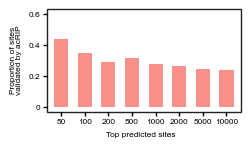

/home/yulab/anaconda3/envs/TandemMod/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 2.5 x 1.33 in image.
/home/yulab/anaconda3/envs/TandemMod/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure/top_predictions_validated_by_acRIP.pdf
/home/yulab/anaconda3/envs/TandemMod/lib/python3.7/site-packages/plotnine/guides/guides.py:200: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


In [55]:
#50 22
#100 35
#200 58
#500 157
#1000 279
#2000 530
#5000 1211
#10000 2400

#plot

import pandas as pd
from plotnine import *
import numpy as np

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'

c1="#F8766D"
c2="#00BA38"
c3="#619CFF"

"""
100 87    55
500 412   283
1000 777  591
2000 1481  1164
5000 3280  2725
10000 5578   4838
20000 9228
"""

X=["50","100","200","500","1000","2000","5000","10000"]
Y=[22/50,35/100,58/200,157/500,279/1000,530/2000,1211/5000,2400/10000]
#training_set=["IVET","IVET","IVET","IVET","IVET","IVET","Curlcake","Curlcake","Curlcake","Curlcake","Curlcake","Curlcake",]
#Y=np.log2(Y_curcake)
data=pd.DataFrame({"Top predicted sites":X,"Proportion of sites\nvalidated by acRIP":Y})

data['Top predicted sites'] = pd.Categorical(data['Top predicted sites'], categories=pd.unique(data['Top predicted sites']))

print(data)
p1 = (ggplot()
        +geom_bar(data,aes(x="Top predicted sites",y = "Proportion of sites\nvalidated by acRIP"),\
                  stat="identity",position="dodge",alpha=0.8,width=0.6,fill=c1)
        +scale_fill_manual(values=[c1,c2])
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            
            #axis_text_x=element_text(rotation=45, hjust=0.5),
            figure_size=[2.5,1.33],
            legend_title = element_text(size=6), #change legend title font size
            legend_text = element_text(size=6),
            legend_background=element_rect(size=0.5,alpha=0),
            #legend_position=(0.60,0.4),
               
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black"),
            
            legend_position=(0.8,0.72),
            legend_key_size=4) #change legend text font size
        #+labs(x = "Kmer length", y ="sequence coverage")
        +guides(color = guide_legend(title = "Probability cutoff"))
        #+ ggtitle("curlcake")
      +ylim([0,0.6])
      +scale_fill_manual(c1)
     )
print(p1)

p1.save('figure/top_predictions_validated_by_acRIP.pdf')